## Hyper Param Optimization
- #### Regularization
- #### Early Stopping
- #### Feature Selection
- #### Parameter scaling

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')
from joblib import dump #Save

---
### Feature Selection - Category 제외

In [47]:
data = pd.read_csv('../dataset/apps_non_cate.csv')

In [48]:
data.columns

Index(['Unnamed: 0', 'Available_Age', 'Size', 'Price', 'Free', 'Rating',
       'Reviews', 'Cate_Int'],
      dtype='object')

### 데이터 살펴보기

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546056 entries, 0 to 546055
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     546056 non-null  int64  
 1   Available_Age  546056 non-null  int64  
 2   Size           546056 non-null  int64  
 3   Price          546056 non-null  int64  
 4   Free           546056 non-null  bool   
 5   Rating         546056 non-null  float64
 6   Reviews        546056 non-null  int64  
 7   Cate_Int       546056 non-null  int64  
dtypes: bool(1), float64(1), int64(6)
memory usage: 29.7 MB


In [50]:
data.duplicated().any() # 중복없음.

False

In [51]:
data['Rating'].value_counts() # 데이터가 0, 5점에 많이 몰려있음.

Rating
5.00    184321
1.00     34169
3.00     27035
4.00     24609
4.50     10849
         ...  
1.06         9
1.04         9
1.05         7
1.03         2
1.02         1
Name: count, Length: 400, dtype: int64

In [52]:
# data.drop(['Unnamed: 0','Category_0','Category_1','Category_2','Category_3','Category_4'], axis=1).boxplot()
# # 1.Reviews 2.Size 3.Price 순으로 수치의 차이가 크다.

In [53]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# # 리뷰수
# axes[0].pie(data['Reviews'], labels=data['Reviews'].index, autopct='%1.1f%%', startangle=90)
# axes[0].set_title('리뷰수')
# # 파일크기
# axes[1].pie(data['Size'], labels=data['Size'].index, autopct='%1.1f%%', startangle=90)
# axes[1].set_title('파일크기(MB)')
# # 가격
# axes[2].pie(data['Price'], labels=data['Price'].index, autopct='%1.1f%%', startangle=90)
# axes[2].set_title('가격')

# plt.tight_layout()
# plt.show()

- Rating 0점,5점 등에 편향
- Reveiws, Size, Price 순으로 편향되어 있음.

In [54]:
X = data.drop(['Rating','Unnamed: 0','Cate_Int'], axis=1)
y = data['Rating']

In [55]:
X,y

(        Available_Age  Size  Price   Free  Reviews
 0                   1    13      0   True        1
 1                   4    25      0   True     1285
 2                   4    60      0   True     1839
 3                   1     3      2  False      242
 4                   4     2      1  False       21
 ...               ...   ...    ...    ...      ...
 546051              1    39      0   True        1
 546052              1    92      0   True        7
 546053              1    16      0   True      143
 546054              1    37      0   True     1500
 546055              1    16      0   True        1
 
 [546056 rows x 5 columns],
 0         5.00
 1         4.78
 2         4.79
 3         4.67
 4         3.10
           ... 
 546051    5.00
 546052    4.43
 546053    3.92
 546054    4.83
 546055    4.00
 Name: Rating, Length: 546056, dtype: float64)

In [56]:
std_scaler = StandardScaler().fit_transform(X)
minmax_scaler = MinMaxScaler().fit_transform(X)
robust_scaler = RobustScaler().fit_transform(X)

std_scaled_df = pd.DataFrame(std_scaler, columns=X.columns)
minmax_scaled_df = pd.DataFrame(minmax_scaler, columns=X.columns)
robust_scaled_df = pd.DataFrame(robust_scaler, columns=X.columns)

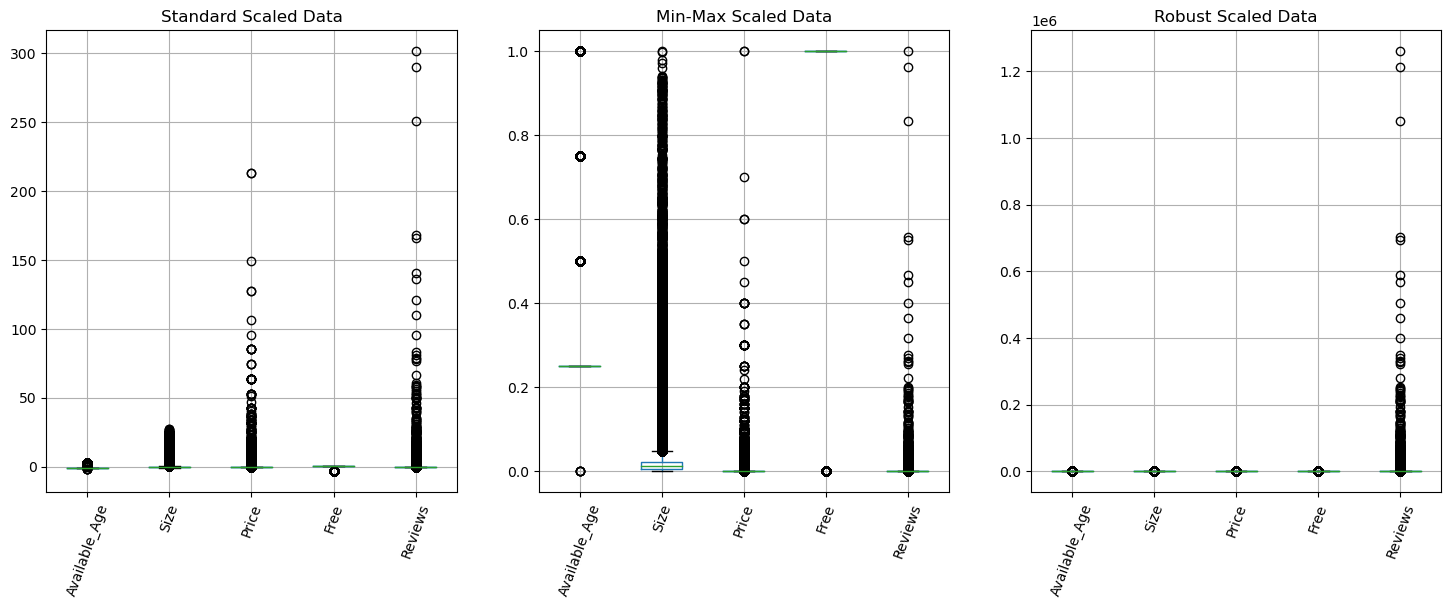

In [57]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Standard Scaled Data')
std_scaled_df.boxplot()
plt.xticks(rotation=70)


plt.subplot(1, 3, 2)
plt.title('Min-Max Scaled Data')
minmax_scaled_df.boxplot()
plt.xticks(rotation=70)


plt.subplot(1, 3, 3)
plt.title('Robust Scaled Data')
robust_scaled_df.boxplot()
plt.xticks(rotation=70)


plt.show()

In [58]:
robust_scaled_df
robust_scaled_df.columns

Index(['Available_Age', 'Size', 'Price', 'Free', 'Reviews'], dtype='object')

---

### 조기 중지(early stopping) 적용해보기

In [61]:
# Assuming X and y are your features and target
# Initial Split - Train and Test
X_train, X_test, y_train, y_test = train_test_split(robust_scaled_df, y, test_size=0.2, random_state=42)

# Train with Early Stopping
model = GradientBoostingRegressor(n_estimators=1000, 
                                  validation_fraction=0.1,  # Fraction of the training data to use as validation
                                  n_iter_no_change=50,      # Stop if 50 iterations with no improvement
                                  tol=0.01,                 # Tolerance for the early stopping
                                  random_state=42)

model.fit(X_train, y_train)

# Final Evaluation
model_performance = model.score(X_test, y_test)


In [62]:
model_performance

0.037816718957692674

In [66]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
print(f'MSE : {mse}')
print(f'MAE : {mae}')
print(f'MSLE : {msle}')

MSE : 1.3757330556055132
MAE : 0.9288890564910626
MSLE : 0.09147938208490862


---

### Regularization (정규화) - 모델 자체를 정규화하여 복잡도를 낮추어 과적합을 방지.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(robust_scaled_df, y, test_size=0.2, random_state=42)

# Initialize the model with regularization parameters
model = GradientBoostingRegressor(
    n_estimators=100, 
    max_depth=3,       # Limits the depth of the trees
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    learning_rate=0.1,  # Controls the contribution of each tree in the ensemble
    random_state=42
)

model.fit(X_train, y_train)
model_performance = model.score(X_test, y_test)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)

print(f'MSE = {mse}')
print(f'MAE = {mae}')
print(f'MSLE = {msle}')

MSE = 1.3741443207512711
MAE = 0.9272786468700052
MSLE = 0.09139754343957511


---

In [25]:
X_train, X_test, y_train, y_test = train_test_split(robust_scaled_df, y,
                                                    test_size=0.2,
                                                    random_state=13
                                                    )

In [59]:
# 모델 준비
LR_model = LinearRegression()
# SVR_model = SVR(kernel='linear', C=1, epsilon=0.1) # param조정
RFR_model = RandomForestRegressor()
DTR_model = DecisionTreeRegressor()
GBR_model = GradientBoostingRegressor()

In [27]:
# 피팅
LR_model.fit(X_train, y_train)

LinearRegression()

In [28]:
# SVR_model.fit(X_train, y_train)

In [29]:
RFR_model.fit(X_train, y_train)

RandomForestRegressor()

In [30]:
DTR_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [31]:
GBR_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [32]:
# 예측
y_pred_lr = LR_model.predict(X_test)
y_pred_rfr = RFR_model.predict(X_test)
y_pred_dtr = DTR_model.predict(X_test)
y_pred_gbr = GBR_model.predict(X_test)
# y_pred_svr = SVR_model.predict(X_test)

In [33]:
# Linear Regression
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print(f"RMSE : {rmse_lr:.4f}")
print(f"MAE : {mae_lr:.4f}")
print(f"MSE : {mse_lr:.4f}")

RMSE : 1.1920
MAE : 0.9539
MSE : 1.4209


In [34]:
# RandomForest
rmse_rfr = mean_squared_error(y_test, y_pred_rfr, squared=False)
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)

print(f"RMSE : {rmse_rfr:.4f}")
print(f"MAE : {mae_rfr:.4f}")
print(f"MSE : {mse_rfr:.4f}")

RMSE : 1.2083
MAE : 0.9462
MSE : 1.4600


In [35]:
# DecisionTreeRegression
rmse_dtr = mean_squared_error(y_test, y_pred_dtr, squared=False)
mae_dtr = mean_absolute_error(y_test, y_pred_dtr)
mse_dtr = mean_squared_error(y_test, y_pred_dtr)

print(f"RMSE : {rmse_dtr:.4f}")
print(f"MAE : {mae_dtr:.4f}")
print(f"MSE : {mse_dtr:.4f}")

RMSE : 1.2559
MAE : 0.9791
MSE : 1.5774


In [36]:
# Gradient Boosting Regression
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)

print(f"RMSE : {rmse_gbr:.4f}")
print(f"MAE : {mae_gbr:.4f}")
print(f"MSE : {mse_gbr:.4f}")

RMSE : 1.1747
MAE : 0.9277
MSE : 1.3800


In [37]:
metrics = {
    'Linear Reg': {'MAE': mae_lr, 'RMSE':rmse_lr,'MSE':mse_lr},
    'Random Forest Reg': {'MAE': mae_rfr, 'RMSE': rmse_rfr,'MSE':mse_rfr},
    'Decision Tree Reg': {'MAE': mae_dtr, 'RMSE': rmse_dtr,'MSE':mse_dtr},
    'Gradient Boosting Reg': {'MAE': mae_gbr, 'RMSE': rmse_gbr,'MSE':mse_gbr}
}
result = pd.DataFrame(metrics).round(3).T
result
    

,MAE,RMSE,MSE
Linear Reg,0.954,1.192,1.421
Random Forest Reg,0.946,1.208,1.460
Decision Tree Reg,0.979,1.256,1.577
Gradient Boosting Reg,0.928,1.175,1.380


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


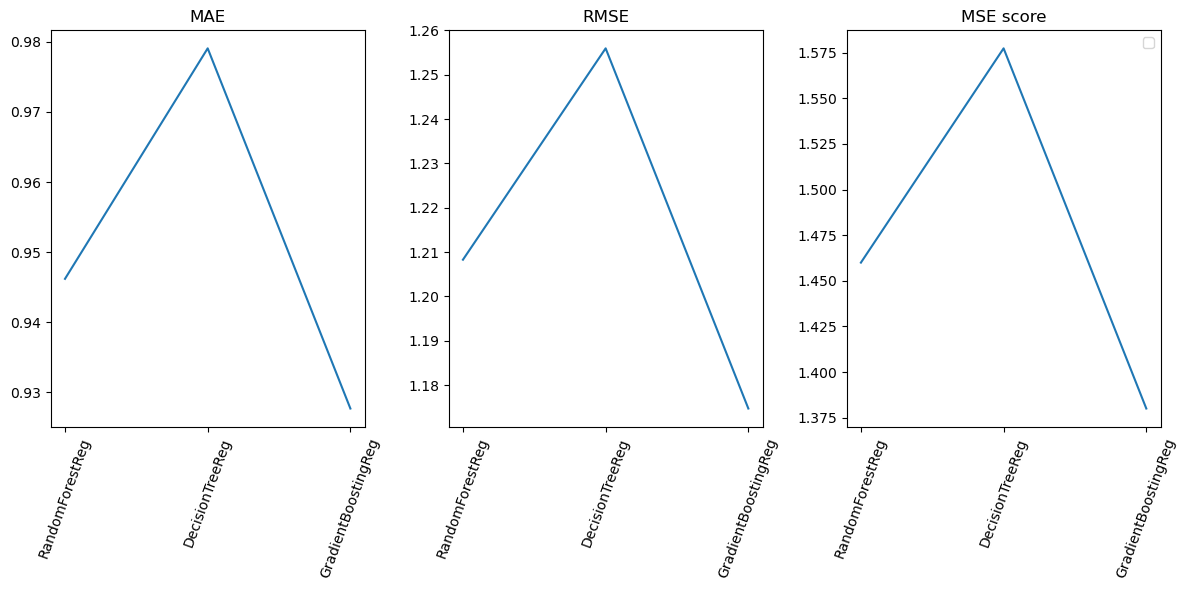

In [38]:
model = ['RandomForestReg','DecisionTreeReg', 'GradientBoostingReg']
mae = [mae_rfr,mae_dtr,mae_gbr]
rmse = [rmse_rfr,rmse_dtr,rmse_gbr]
mse = [mse_rfr,mse_dtr,mse_gbr]

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(model,mae)
plt.title('MAE')
plt.xticks(rotation=70)

plt.subplot(1,3,2)
plt.plot(model,rmse)
plt.title('RMSE')
plt.xticks(rotation=70)

plt.subplot(1,3,3)
plt.plot(model, mse)
plt.title('MSE score')
plt.xticks(rotation=70)
plt.tight_layout()
plt.legend()
plt.show()

In [39]:
# 교차 검증 
kf = KFold(n_splits=5)
total = 0

for train, valid in kf.split(X):
    X_train, X_valid = X.iloc[train], X.iloc[valid]
    y_train, y_vaild = y.iloc[train], y.iloc[valid]

    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    rmse = mean_squared_error(y_vaild, y_pred, squared=False)
    mae = mean_absolute_error(y_vaild, y_pred)
    mse = mean_squared_error(y_vaild, y_pred)
    total += rmse
    print(f'RMSE : {rmse:.3f}  ', end='')
    print(f'MAE : {mae:.3f}  ', end='')
    print(f'MSE : {mse:.3f}')

print(f'MSE Avg : {total/5}')

RMSE : 1.184  MAE : 0.945  MSE : 1.403
RMSE : 1.166  MAE : 0.915  MSE : 1.359
RMSE : 1.122  MAE : 0.880  MSE : 1.260
RMSE : 1.150  MAE : 0.920  MSE : 1.322
RMSE : 1.240  MAE : 0.984  MSE : 1.537
MSE Avg : 1.1723942659551727


In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators' : [100,200,300],
    'max_depth' : [3, 4,5]
}

gridserch = GridSearchCV(estimator=GBR_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)
gridserch.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=3)

In [42]:
print(gridserch.best_params_)
print(gridserch.best_score_)
print(gridserch.best_estimator_)

{'max_depth': 5, 'n_estimators': 200}
-0.9084397591463809
GradientBoostingRegressor(max_depth=5, n_estimators=200)


In [43]:
model_tuned = GradientBoostingRegressor(n_estimators=200, max_depth=5)
model_tuned.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200)

In [44]:
y_pred_tuned = model_tuned.predict(X_test)

mse_tuned = mean_squared_error(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
print(f'Tuned MSE : {mse_tuned}')
print(f'Tuned MAE : {mae_tuned}')

Tuned MSE : 1.7884917217717873
Tuned MAE : 1.1705258727404835


In [45]:
result = {
    'GBR_before': {'MSE': mse_gbr, 'MAE': mae_gbr},
    'GBR_tuned': {'MSE': mse_tuned, 'MAE': mae_tuned}
}
res = pd.DataFrame(result).round(3)
res

,GBR_before,GBR_tuned
MSE,1.380,1.788
MAE,0.928,1.171


### 모델의 복잡도를 높이면 모델이 이상치를 더 잘 학습하게되어 과적합이 일어날 수 있다.
- train data를 더 만들거나 regularization을 적용하거나, 모델의 구조를 단순화하여 복잡도를 더 낮출 수 있다.
- feature을 조정하는 것도 방법이다. (Category out?)

In [34]:
# from bokeh.plotting import figure, show

# fruits = ['Apples', 'Pears', 'Kiwis', 'Plums', 'Bananas', 'Strawberries']
# counts = [5,3,6,2,7,10]

# # Sort Values
# sorted_fruits = sorted(fruits, key=lambda x: counts[fruits.index(x)])

# p = figure(x_range=sorted_fruits, height=250, title="Counting Fruits", toolbar_location=None, tools="")

# p.vbar(x=fruits, top=counts, width=0.95)
# p.y_range.start = 0
# p.xgrid.grid_line_color=None
# show(p)